In [1]:
import sys
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

path = os.path.join('..', '/Users/dylandissanayake/Desktop/DPhil/Comp Disc/Repositories/TB-PNCA-GNN') if "SSH_CONNECTION" not in os.environ else os.path.join('..', '/mnt/alphafold-volume-1/dylan2/repos/tb-pnca-gnn')
if path not in sys.path:
    sys.path.append(os.path.abspath(path))

from src import evaluation

import pickle as pkl

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

%aimport src

### Reproduce bootstrapping from Carter et al

Same sampling method - each of the 10 samples is the same as in Carter et al

- Get mutations/indexes of ds-test.npy for the samples
- Use the same sample for the bootstraps for evaluation

In [3]:
from sklearn.utils import resample

from statsmodels.stats.weightstats import ztest as ztest

In [4]:
# load the training dataset
X={}
Y={}
Z={}
X['train']={}
Y['train']={}
Z['train']={}
with open('../data/ds-train.npy', 'rb') as f:
    Y['train']['input'] = np.load(f)
    X['train']['input'] = np.load(f)
    Z['train']['input'] = np.load(f, allow_pickle=True)

# load the test dataset
X['test']={}
Y['test']={}
Z['test']={}
with open('../data/ds-test.npy', 'rb') as f:
    Y['test']['input'] = np.load(f)
    X['test']['input'] = np.load(f)
    Z['test']['input'] = np.load(f, allow_pickle=True)
    

In [5]:
number_of_bootstraps = 10

def bootstrap_model(features, labels, mutations):
    x={}
    y={}
    z = {}
    for i in range(number_of_bootstraps):
        x[i],y[i], z[i] = resample(features['test']['input'], labels['test']['input'], mutations['test']['input'], random_state=42+i)

    return x, y, z

In [6]:
x, y, z = bootstrap_model(X, Y, Z)

In [7]:
z

{0: array(['V128G', 'A46S', 'I52N', 'H57Q', 'H43Y', 'G17S', 'F58Y', 'A30P',
        'V128G', 'R176G', 'N11I', 'S88T', 'S59T', 'A46E', 'H82L', 'G108R',
        'Q122L', 'R123C', 'A20E', 'G78D', 'S88T', 'D86N', 'M175I', 'E144G',
        'D49G', 'I90S', 'A30P', 'R29C', 'D110N', 'L116P', 'Q10H', 'F13V',
        'A178D', 'G97D', 'I90S', 'H57Q', 'Q141E', 'Q141E', 'A38S', 'Q141E',
        'D129E', 'Q10P', 'A20S', 'V45L', 'Q122L', 'D129E', 'V139L', 'A30P',
        'A79S', 'L4F', 'P54T', 'H71D', 'Q10H', 'G75D', 'K48T', 'L172R',
        'E173K', 'A20E', 'E144G', 'G16S', 'A3V', 'G60D', 'I90S', 'A20T',
        'A143D', 'E127K', 'A38S', 'A36V', 'R123L', 'H57P', 'I90F', 'H82L',
        'H71D', 'G78D', 'I6F', 'C184Y', 'A79T', 'P62L', 'C184Y', 'E107Q',
        'G124A', 'D49E', 'I31N', 'Q141E', 'K48T', 'L182W', 'S32I', 'H57Q',
        'V7D', 'Q141E', 'L182M', 'Y103D', 'G60D', 'A20E', 'D110V', 'T168A',
        'I90S', 'V163M', 'V157A', 'N112Y', 'H57Q', 'Y95N', 'F50Y', 'Q10H',
        'D8G', 'L172R', 'S8

### Select bootstrapped samples from GCN dataset

In [8]:
# with open('./datasets/normed_singletons_af_w_pza_graph_dict.pkl', 'rb') as f:
with open('./datasets/x18_exp_l2_graph_dict.pkl', 'rb') as f:
    
    data = pkl.load(f)

In [9]:
next(iter(data['test'].items()))[1]['graph']

In [10]:
# map mutation to dictionary key

mut_map = {}

for k, v in data['test'].items():
    key = k
    value = v['metadata']['mutation'].values[0]
    mut_map[value] = key

mut_map

{'I90T': 'pnca_mut_99',
 'A161T': 'pnca_mut_3',
 'V7F': 'pnca_mut_188',
 'A39S': 'pnca_mut_15',
 'R123G': 'pnca_mut_142',
 'D86N': 'pnca_mut_38',
 'S104I': 'pnca_mut_150',
 'L116R': 'pnca_mut_104',
 'E91D': 'pnca_mut_53',
 'D8H': 'pnca_mut_41',
 'L35V': 'pnca_mut_116',
 'N149D': 'pnca_mut_129',
 'Y95N': 'pnca_mut_197',
 'V45L': 'pnca_mut_185',
 'H57Q': 'pnca_mut_86',
 'I31N': 'pnca_mut_94',
 'F81S': 'pnca_mut_61',
 'Q10H': 'pnca_mut_136',
 'L172Q': 'pnca_mut_109',
 'N112S': 'pnca_mut_124',
 'G23A': 'pnca_mut_73',
 'A46S': 'pnca_mut_18',
 'D49Y': 'pnca_mut_33',
 'V128G': 'pnca_mut_170',
 'D129E': 'pnca_mut_27',
 'D63N': 'pnca_mut_35',
 'T100A': 'pnca_mut_162',
 'A36V': 'pnca_mut_13',
 'R123L': 'pnca_mut_144',
 'T76S': 'pnca_mut_169',
 'S32R': 'pnca_mut_156',
 'K96T': 'pnca_mut_102',
 'F13V': 'pnca_mut_55',
 'E15G': 'pnca_mut_47',
 'L172R': 'pnca_mut_110',
 'G75V': 'pnca_mut_78',
 'A20E': 'pnca_mut_5',
 'G124D': 'pnca_mut_67',
 'N149H': 'pnca_mut_130',
 'F58I': 'pnca_mut_58',
 'M175L': '

In [11]:
bootstrapped_data = {}

for i in z:
    bootstrapped_data[i] = []
    for sample in z[i]:
        dict_sample = mut_map[sample]
        bootstrapped_data[i].append(data['test'][dict_sample])
        

In [12]:
# check bootstrapping matches

for i in z:
    for j,_ in enumerate(z[i]):
        assert z[i][j] == bootstrapped_data[i][j]['metadata']['mutation'].values[0]

### Evaluate GCN with bootstrapped sampling

In [13]:
bootstrapped_data[0][0]['graph'].dataset[0].x

tensor([[0.6130, 0.1149, 0.5740,  ..., 0.7359, 0.1325, 0.0000],
        [0.6756, 0.5621, 0.7676,  ..., 0.7359, 0.1325, 0.0000],
        [0.1699, 0.3540, 0.1084,  ..., 0.7359, 0.1325, 0.0000],
        ...,
        [0.4764, 0.0870, 0.3253,  ..., 0.7359, 0.1325, 0.0000],
        [0.2886, 0.3199, 0.3571,  ..., 0.7359, 0.1325, 0.0000],
        [0.1723, 0.3540, 0.2324,  ..., 0.7359, 0.1325, 0.0000]])

In [14]:
# # correct graph for model cutoff and edges
# cutoff_distance = 12
# edge_weight_func = "exp"
# edge_weight_lambda = 2

In [15]:
# for b in tqdm(bootstrapped_data):
#     for sample in bootstrapped_data[b]:
#         graph = sample['graph']
        
#         # reset graph attributes based on new cutoff distance
#         graph.cutoff_distance = cutoff_distance
        
#         # calc new edge index and edge weights
#         edge_index, d_array = graph._get_protein_struct_edges(graph.nodes.center_of_mass(compound='residues'))
#         edge_dists = graph._gen_edge_dists(edge_index, d_array)
#         edge_attr = graph.calc_edge_weights(edge_weight_func, edge_dists, edge_weight_lambda)
        
#         # normalise edge weights
#         edge_attr = graph.process_edge_weights(edge_attr)
        
#         # change edge index and edge weights for Data object
#         sample['graph'].dataset[0].edge_index = edge_index
#         sample['graph'].dataset[0].edge_attr = edge_attr

In [16]:
from torch_geometric.data import DataLoader

# create data loaders for each bootstrap sample
data_loaders = {}

for b in bootstrapped_data:

    loader = DataLoader([sample['graph'].dataset[0] for sample in bootstrapped_data[b]],
                          batch_size=256,
                          shuffle=False)
    
    data_loaders[b] = loader

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [38]:
# model = torch.load("saved_models/train-final-model/Run 3 - 1150 epochs/F1=0.808_epoch=903.pth")
model = torch.load("saved_models/18_node_feats-Run_4-2000_epochs/F1=0.816_epoch=1119.pth", map_location='cpu')
# model = torch.load("saved_models/18_node_feats-Run_8-1500_epochs/F1=0.816_epoch=1233.pth", map_location='cpu')

/var/folders/l5/vrm1h_ss1_l4hs0jcrxrr_0c0000gn/T/ipykernel_14092/3602036641.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("saved_models/18_node_feat

In [39]:
def evaluate_bootstrap_model(model, data_loaders, show_roc=False):
    sens = []
    spec = []
    roc_auc = []
    f1 = []
    for b in data_loaders:
        print(f"Bootstrap {b}:")

        fpr, tpr, roc_auc_res = evaluation.calculate_roc(model, data_loaders[b])
        if show_roc:
            evaluation.plot_roc_curve(fpr, tpr, roc_auc)
        sens_res,spec_res,f1_res, cm_res = evaluation.calculate_metrics(model, data_loaders[b])
        sens.append(sens_res)
        spec.append(spec_res)
        f1.append(f1_res)
        roc_auc.append(roc_auc_res)

        print("\n --- \n")
        
    return {"sensitivity": sens, "specificity": spec, "f1": f1, "roc_auc": roc_auc, "confusion_matrix": cm_res}

In [40]:
gcn_results = evaluate_bootstrap_model(model, data_loaders, show_roc=False)

Bootstrap 0:
Number predicted resistant = 106. Number labeled R = 106
Number predicted susceptible = 94. Number labeled S = 94
Sensitivity: 0.802
Specificity: 0.777
F1 Score: 0.802
Confusion Matrix:
[[73 21]
 [21 85]]

 --- 

Bootstrap 1:
Number predicted resistant = 118. Number labeled R = 121
Number predicted susceptible = 82. Number labeled S = 79
Sensitivity: 0.851
Specificity: 0.810
F1 Score: 0.862
Confusion Matrix:
[[ 64  15]
 [ 18 103]]

 --- 

Bootstrap 2:
Number predicted resistant = 100. Number labeled R = 90
Number predicted susceptible = 100. Number labeled S = 110
Sensitivity: 0.889
Specificity: 0.818
F1 Score: 0.842
Confusion Matrix:
[[90 20]
 [10 80]]

 --- 

Bootstrap 3:
Number predicted resistant = 107. Number labeled R = 109
Number predicted susceptible = 93. Number labeled S = 91
Sensitivity: 0.835
Specificity: 0.824
F1 Score: 0.843
Confusion Matrix:
[[75 16]
 [18 91]]

 --- 

Bootstrap 4:
Number predicted resistant = 96. Number labeled R = 92
Number predicted suscep

### Evaluate vs Carter et al results

In [ ]:
carter_data = {
    "model": ["LR", "NN", "XB", "LR", "LR", "LR", "LR", "LR", "LR", "LR", "LR", "LR", "LR",
              "NN", "NN", "NN", "NN", "NN", "NN", "NN", "NN", "NN", "NN",
              "XB", "XB", "XB", "XB", "XB", "XB", "XB", "XB", "XB", "XB",
              "LR", "NN", "XB"],
    "dataset": ["test", "test", "test", "test_0", "test_1", "test_2", "test_3", "test_4", "test_5", "test_6", "test_7", "test_8", "test_9",
                "test_0", "test_1", "test_2", "test_3", "test_4", "test_5", "test_6", "test_7", "test_8", "test_9",
                "test_0", "test_1", "test_2", "test_3", "test_4", "test_5", "test_6", "test_7", "test_8", "test_9",
                "bootstrapped", "bootstrapped", "bootstrapped"],
    "f1_mean": [None]*36,
    "f1_std": [None]*36,
    "sensitivity_mean": [79.611650, 75.728155, 80.582524, 77.358491, 84.297521, 82.222222, 81.651376, 78.260870, 82.692308,
                         74.193548, 77.981651, 81.188119, 74.166667, 74.528302, 80.165289, 81.111111, 79.816514, 77.173913,
                         78.846154, 76.344086, 75.229358, 78.217822, 69.166667, 80.188679, 86.776860, 78.888889, 83.486239,
                         78.260870, 78.846154, 77.419355, 81.651376, 85.148515, 75.833333, 79.401277, 77.059922, 80.650027],
    "sensitivity_std": [None]*33 + [2.196483, 2.174477, 2.193639],
    "specificity_mean": [72.164948, 58.762887, 78.350515, 69.148936, 68.354430, 70.000000, 75.824176, 70.370370, 66.666667,
                         68.224299, 72.527473, 73.737374, 70.000000, 59.574468, 54.430380, 62.727273, 63.736264, 60.185185,
                         60.416667, 54.205607, 62.637363, 64.646465, 55.000000, 79.787234, 82.278481, 82.727273, 83.516484,
                         76.851852, 82.291667, 75.700935, 84.615385, 76.767677, 80.000000, 70.485372, 59.755967, 80.453699],
    "specificity_std": [None]*33 + [1.725528, 2.438712, 1.942238],
    "roc_auc_mean": [82.784506, 75.097588, 82.234011, 80.750703, 85.594727, 85.606061, 82.810767, 82.357085, 84.805689,
                     77.710783, 81.963908, 82.058206, 78.906250, 75.827981, 78.423475, 79.646465, 79.574554, 76.846820,
                     78.625801, 72.625867, 77.175118, 75.967597, 63.968750, 82.346447, 86.211947, 82.757576, 85.341264,
                     80.485105, 83.383413, 78.605165, 85.462244, 85.638564, 80.552083, 82.256418, 75.868243, 83.078381],
    "roc_auc_std": [None]*36,
    "TN": [70, 57, 76, 65, 54, 77, 69, 76, 64, 73, 66, 73, 56, 56, 43, 69, 58, 65, 58, 58, 57, 64, 44,
           75, 65, 91, 76, 83, 79, 81, 77, 76, 64] + [None]*3,
    "FP": [27, 40, 21, 29, 25, 33, 22, 32, 32, 34, 25, 26, 24, 38, 36, 41, 33, 43, 38, 49, 34, 35, 36,
           19, 14, 19, 15, 25, 17, 26, 14, 23, 16] + [None]*3,
    "FN": [21, 25, 20, 24, 19, 16, 20, 20, 18, 24, 24, 19, 31, 27, 24, 17, 22, 21, 22, 22, 27, 22, 37,
           21, 16, 19, 18, 20, 22, 21, 20, 15, 29] + [None]*3,
    "TP": [82, 78, 83, 82, 102, 74, 89, 72, 86, 69, 85, 82, 89, 79, 97, 73, 87, 71, 82, 71, 82, 79, 83,
           85, 105, 71, 91, 72, 82, 72, 89, 86, 91] + [None]*3,
}

model_results = pd.DataFrame(carter_data)

In [64]:
def compute_f1(tp, fp, fn):
    precision = tp / (tp + fp) if (tp + fp) else 0
    recall = tp / (tp + fn) if (tp + fn) else 0
    return 2 * precision * recall / (precision + recall) if (precision + recall) else 0

In [ ]:
model_results['f1_mean'] = model_results.apply(lambda row: 100*compute_f1(row["TP"], row["FP"], row["FN"]), axis=1)

In [66]:
def confidence_interval_width(data, confidence=0.95):
    arr = np.array(data)
    n = len(arr)
    sem = stats.sem(arr)
    # h = sem * stats.t.ppf((1 + confidence) / 2., n-1)
    h = 1.96 * sem
    return h

In [ ]:
for m in ['LR', 'NN', 'XB']:
    f1_vals = model_results[
        (model_results['model'] == m) & (
            model_results['dataset'].isin([f"test_{n}" for n in range(10)])
            )
        ]['f1_mean'].values
    
    roc_auc_vals = model_results[
        (model_results['model'] == m) & (
            model_results['dataset'].isin([f"test_{n}" for n in range(10)])
            )
        ]['roc_auc_mean'].values

    bootstrap_f1_mean = f1_vals.mean()

    model_results.loc[
            ((model_results['model'] == m) & (model_results['dataset'] == "bootstrapped")), "f1_mean"
            ] = bootstrap_f1_mean
    
    model_results.loc[
            ((model_results['model'] == m) & (model_results['dataset'] == "bootstrapped")), "f1_std"
            ] = confidence_interval_width(f1_vals)
    
    model_results.loc[
            ((model_results['model'] == m) & (model_results['dataset'] == "bootstrapped")), "roc_auc_std"
            ] = confidence_interval_width(roc_auc_vals)
    
    

In [ ]:
# xb_sens = model_results.loc[(model_results['model'] == "XB") & (
#         model_results['dataset'].isin([f"test_{n}" for n in range(10)])
#         ), "sensitivity_mean"].values * 0.01
# xb_spec = model_results.loc[(model_results['model'] == "XB") & (
#         model_results['dataset'].isin([f"test_{n}" for n in range(10)])
#         ), "specificity_mean"].values * 0.01
# xb_f1 = model_results.loc[(model_results['model'] == "XB") & (
#         model_results['dataset'].isin([f"test_{n}" for n in range(10)])
#         ), "f1_mean"].values * 0.01
# xb_roc_auc = model_results.loc[(model_results['model'] == "XB") & (
#         model_results['dataset'].isin([f"test_{n}" for n in range(10)])
#         ), "roc_auc_mean"].values * 0.01

In [56]:
# print("GCN Sensitivity Mean:", np.round(np.mean(gcn_results['sensitivity']), 3))
# print("GCN Specificity Mean:", np.round(np.mean(gcn_results['specificity']), 3))
# print("GCN F1 Mean:", np.round(np.mean(gcn_results['f1']), 3))
# print("GCN ROC AUC Mean:", np.round(np.mean(gcn_results['roc_auc']), 3))

In [57]:
# print("XB Sensitivity Mean:", np.round(np.mean(xb_sens), 3))
# print("XB Specificity Mean:", np.round(np.mean(xb_spec), 3))
# print("XB F1 Mean:", np.round(np.mean(xb_f1), 3))
# print("XB ROC AUC Mean:", np.round(np.mean(xb_roc_auc), 3))

In [68]:
gcn_sens_width = confidence_interval_width(gcn_results['sensitivity'])*100
gcn_spec_width = confidence_interval_width(gcn_results['specificity'])*100
gcn_f1_width = confidence_interval_width(gcn_results['f1'])*100
gcn_roc_auc_width = confidence_interval_width(gcn_results['roc_auc'])*100

# print(f"GCN Sensitivity 95% CI width: {gcn_sens_width:.2f}")
# print(f"GCN Specificity 95% CI width: {gcn_spec_width:.2f}")
# print(f"GCN F1 95% CI width: {gcn_f1_width:.2f}")
# print(f"GCN ROC AUC 95% CI width: {gcn_roc_auc_width:.2f}")


In [59]:
# xb_sens_width = confidence_interval_width(xb_sens)*100
# xb_spec_width = confidence_interval_width(xb_spec)*100
# xb_f1_width = confidence_interval_width(xb_f1)*100
# xb_roc_auc_width = confidence_interval_width(xb_roc_auc)*100

# print(f"XB Sensitivity 95% CI width: {xb_sens_width:.2f}")
# print(f"XB Specificity 95% CI width: {xb_spec_width:.2f}")
# print(f"XB F1 95% CI width: {xb_f1_width:.2f}")
# print(f"XB ROC AUC 95% CI width: {xb_roc_auc_width:.2f}")

In [70]:
gcn_results_row = ["GCN", 
                   "bootstrapped",
                    np.mean(gcn_results['f1'])*100,
                    gcn_f1_width,
                    np.mean(gcn_results['sensitivity'])*100,
                    gcn_sens_width,
                    np.mean(gcn_results['specificity'])*100,
                    gcn_spec_width,
                    np.mean(gcn_results['roc_auc'])*100,
                    gcn_roc_auc_width,
                    np.nan,
                    np.nan,
                    np.nan,
                    np.nan,
                   ]

In [ ]:
model_results.loc[len(model_results)] = gcn_results_row

In [ ]:
model_results

,model,dataset,f1_mean,f1_std,sensitivity_mean,sensitivity_std,specificity_mean,specificity_std,roc_auc_mean,roc_auc_std,TN,FP,FN,TP
0,LR,test,77.358491,None,79.611650,NaN,72.164948,NaN,82.784506,None,70.0,27.0,21.0,82.0
1,NN,test,70.588235,None,75.728155,NaN,58.762887,NaN,75.097588,None,57.0,40.0,25.0,78.0
2,XB,test,80.193237,None,80.582524,NaN,78.350515,NaN,82.234011,None,76.0,21.0,20.0,83.0
3,LR,test_0,75.576037,None,77.358491,NaN,69.148936,NaN,80.750703,None,65.0,29.0,24.0,82.0
4,LR,test_1,82.258065,None,84.297521,NaN,68.354430,NaN,85.594727,None,54.0,25.0,19.0,102.0
5,LR,test_2,75.126904,None,82.222222,NaN,70.000000,NaN,85.606061,None,77.0,33.0,16.0,74.0
6,LR,test_3,80.909091,None,81.651376,NaN,75.824176,NaN,82.810767,None,69.0,22.0,20.0,89.0
7,LR,test_4,73.469388,None,78.260870,NaN,70.370370,NaN,82.357085,None,76.0,32.0,20.0,72.0
8,LR,test_5,77.477477,None,82.692308,NaN,66.666667,NaN,84.805689,None,64.0,32.0,18.0,86.0
9,LR,test_6,70.408163,None,74.193548,NaN,68.224299,NaN,77.710783,None,73.0,34.0,24.0,69.0


In [90]:
for idx in range(10):
    row = {
        "model": "GCN",
        "dataset": f"test_{idx}",
        "f1_mean": gcn_results['f1'][idx]*100,
        "f1_std": None,
        "sensitivity_mean": gcn_results['sensitivity'][idx]*100,
        "sensitivity_std": None,
        "specificity_mean": gcn_results['specificity'][idx]*100,
        "specificity_std": None,
        "roc_auc_mean": gcn_results['roc_auc'][idx]*100,
        "roc_auc_std": None,
        "TN": None,
        "FP": None,
        "FN": None,
        "TP": None,
    }
    model_results.loc[len(model_results)] = row

/var/folders/l5/vrm1h_ss1_l4hs0jcrxrr_0c0000gn/T/ipykernel_14092/1135331607.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_results.loc[len(model_results)] = row
/var/folders/l5/vrm1h_ss1_l4hs0jcrxrr_0c0000gn/T/ipykernel_14092/1135331607.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_results.loc[len(model_results)] = row
/var/folders/l5/vrm1h_ss1_l4hs0jcrxrr_0c0000gn/T/ipykernel_14092/1135331607.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or al

In [91]:
model_results

,model,dataset,f1_mean,f1_std,sensitivity_mean,sensitivity_std,specificity_mean,specificity_std,roc_auc_mean,roc_auc_std,TN,FP,FN,TP
0,LR,test,77.358491,None,79.611650,NaN,72.164948,NaN,82.784506,None,70.0,27.0,21.0,82.0
1,NN,test,70.588235,None,75.728155,NaN,58.762887,NaN,75.097588,None,57.0,40.0,25.0,78.0
2,XB,test,80.193237,None,80.582524,NaN,78.350515,NaN,82.234011,None,76.0,21.0,20.0,83.0
3,LR,test_0,75.576037,None,77.358491,NaN,69.148936,NaN,80.750703,None,65.0,29.0,24.0,82.0
4,LR,test_1,82.258065,None,84.297521,NaN,68.354430,NaN,85.594727,None,54.0,25.0,19.0,102.0
5,LR,test_2,75.126904,None,82.222222,NaN,70.000000,NaN,85.606061,None,77.0,33.0,16.0,74.0
6,LR,test_3,80.909091,None,81.651376,NaN,75.824176,NaN,82.810767,None,69.0,22.0,20.0,89.0
7,LR,test_4,73.469388,None,78.260870,NaN,70.370370,NaN,82.357085,None,76.0,32.0,20.0,72.0
8,LR,test_5,77.477477,None,82.692308,NaN,66.666667,NaN,84.805689,None,64.0,32.0,18.0,86.0
9,LR,test_6,70.408163,None,74.193548,NaN,68.224299,NaN,77.710783,None,73.0,34.0,24.0,69.0


In [ ]:
# from scipy.stats import ttest_rel

# sens_t_stat, sens_p_val = ttest_rel(gcn_results['sensitivity'], xb_sens)
# spec_t_stat, spec_p_val = ttest_rel(gcn_results['specificity'], xb_spec)
# roc_auc_t_stat, roc_auc_p_val = ttest_rel(gcn_results['roc_auc'], xb_roc_auc)
# f1_t_stat, f1_p_val = ttest_rel(gcn_results['f1'], xb_f1)


In [ ]:
# sens_p_val, spec_p_val,  f1_p_val, roc_auc_p_val

(0.5550434536460769,
 0.38361264964855835,
 0.6891549981762295,
 0.10217994257241667)

In [ ]:
# model_results.loc[(model_results['model'] == 'XB') & (
#             model_results['dataset'].isin(bsap_list)), 'sensitivity_mean']

23    80.188679
24    86.776860
25    78.888889
26    83.486239
27    78.260870
28    78.846154
29    77.419355
30    81.651376
31    85.148515
32    75.833333
Name: sensitivity_mean, dtype: float64

In [147]:
models = ['LR', 'NN', 'XB', 'GCN']
bsap_list = [f"test_{n}" for n in range(10)]
metrics = ['f1_mean', 'sensitivity_mean', 'specificity_mean', 'roc_auc_mean']
for ind, model in enumerate(models):
    for model_2 in models[ind+1:]:
        if model == model_2 or (model != 'GCN' and model_2 != 'GCN'):
            continue
        for metric in metrics:
            t_stat, p_val = ttest_rel(
                model_results.loc[(model_results['model'] == model) & (model_results['dataset'].isin(bsap_list)), metric],
                model_results.loc[(model_results['model'] == model_2) & (model_results['dataset'].isin(bsap_list)), metric]
            )
            if p_val <= 0.05:
                print(f"{model} vs {model_2} {metric}: t-statistic = {t_stat:.3f}, p-value = {p_val}")
                if p_val <= 0.001:
                    stars = '***'
                elif p_val <= 0.01:
                    stars = '**'
                elif p_val <= 0.05:
                    stars = '*'
                else:
                    stars = ''
                print(f"Significance: {stars}")

LR vs GCN f1_mean: t-statistic = -6.231, p-value = 0.00015305978182598266
Significance: ***
LR vs GCN sensitivity_mean: t-statistic = -3.362, p-value = 0.008368306277418898
Significance: **
LR vs GCN specificity_mean: t-statistic = -8.054, p-value = 2.096545635164292e-05
Significance: ***
NN vs GCN f1_mean: t-statistic = -15.396, p-value = 8.992252647362142e-08
Significance: ***
NN vs GCN sensitivity_mean: t-statistic = -5.446, p-value = 0.00040764451022776333
Significance: ***
NN vs GCN specificity_mean: t-statistic = -15.254, p-value = 9.749018229279952e-08
Significance: ***
NN vs GCN roc_auc_mean: t-statistic = -6.262, p-value = 0.00014748183972504986
Significance: ***


### Create Results Bar Chart

In [97]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['axes.labelsize'] = 12

In [98]:
colours = ['#e41a1c',
           '#377eb8',
           '#4daf4a',
           '#984ea3',
           ]


# Use the last 4 rows of model_results for the metrics
model_metrics = model_results[model_results['dataset'] == 'bootstrapped'][::-1]
models = model_metrics['model'].values

metrics = {
    'F1': (
        model_metrics['f1_mean'].values,
        model_metrics['f1_std'].astype(float).values
    ),
    'Sensitivity': (
        model_metrics['sensitivity_mean'].values,
        model_metrics['sensitivity_std'].astype(float).values
    ),
    'Specificity': (
        model_metrics['specificity_mean'].values,
        model_metrics['specificity_std'].astype(float).values
    ),
    'ROC AUC': (
        model_metrics['roc_auc_mean'].values,
        model_metrics['roc_auc_std'].astype(float).values
    ),
}


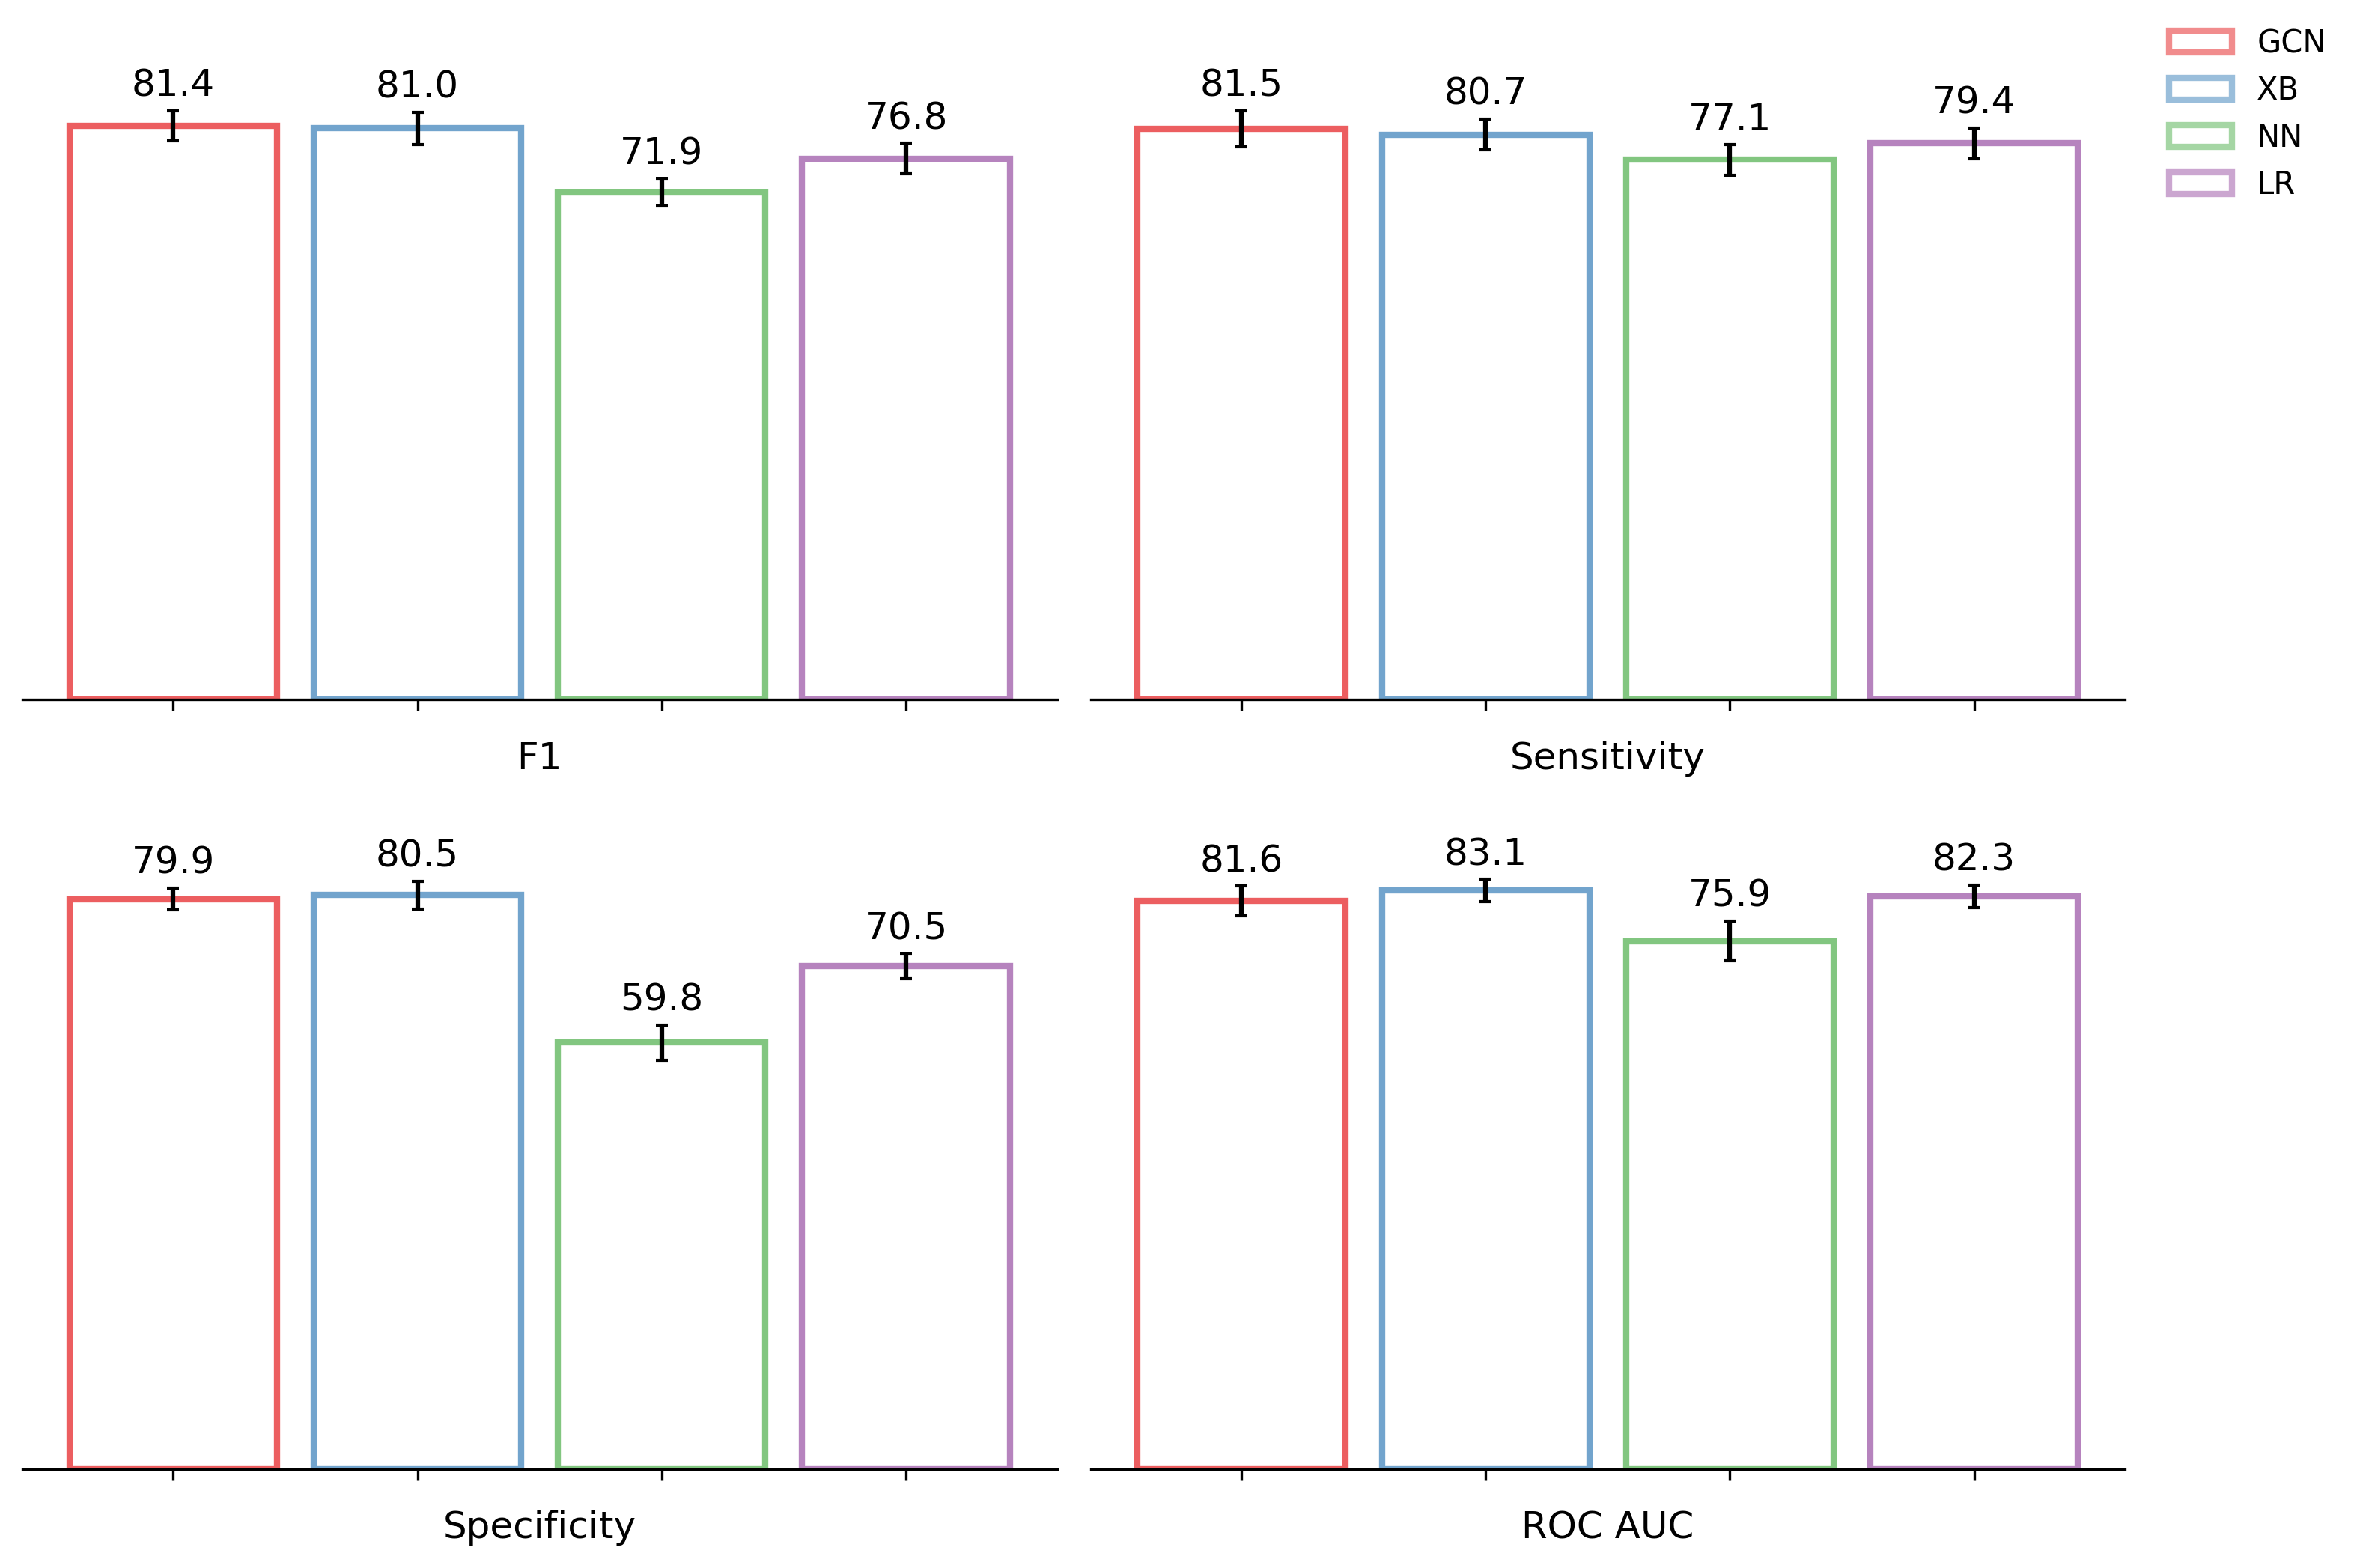

In [143]:
fig, axs = plt.subplots(2, 2, figsize=(10.5,7))
# fig, axs = plt.subplots(1, 4, figsize=(10,3))

for i, (metric, (vals, errs)) in enumerate(metrics.items()):
    ax = axs[i // 2, i % 2]
    x = np.arange(len(models))
    
    bars = ax.bar(x, vals, yerr=errs, capsize=2, width=0.85, 
                  color='white', edgecolor=colours,
                  linewidth=2,
                  alpha=0.7
                  )

    # metric values labelled above bars
    for bar, value, error in zip(bars, vals, errs):
        ax.text(bar.get_x() + bar.get_width() / 2, value + error + 1, f'{value:.1f}',
                ha='center', va='bottom',
                fontsize=12,
                # color='black'
                )

    # metric label below x axis, x ticks but no labels
    ax.set_xlabel(metric, labelpad=6)
    ax.set_xticks(np.arange(len(models)))
    ax.set_xticklabels([])
    
    ax.set_ylim(0, max(vals + errs) + 10)
    ax.spines[['top', 'right', 'left']].set_visible(False)
    ax.tick_params(left=False, labelleft=False)

# legend
legend_elements = [Patch(facecolor="white", alpha=0.5, edgecolor=colours[i], linewidth=2, label=models[i]) for i in range(len(models))]
fig.legend(handles=legend_elements, loc='upper right', 
           frameon=False)

plt.tight_layout(rect=[0, 0, 0.92, 1])  # space for legend on right
plt.show()

### Evaluate full Test set

In [41]:
loader = DataLoader([data['test'][sample]['graph'].dataset[0] for sample in data['test']],
                          batch_size=256,
                          shuffle=False)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
test_sens, test_spec, test_f1, test_cm = evaluation.calculate_metrics(model, loader)
fpr, tpr, test_roc_auc = evaluation.calculate_roc(model, loader)

Number predicted resistant = 103. Number labeled R = 103
Number predicted susceptible = 97. Number labeled S = 97
Sensitivity: 0.816
Specificity: 0.804
F1 Score: 0.816
Confusion Matrix:
[[78 19]
 [19 84]]
